<a href="https://colab.research.google.com/github/malgorzatagwinner/text_classification/blob/main/frequencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
PATH = '/content/drive/My Drive/Colab Notebooks/frequencies/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q tsai[extras]
from tsai.all import *
import sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('punkt')
import string
from tqdm.notebook import tqdm_notebook
import glob
from collections import Counter
import os
from os.path import exists
import pickle
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import numpy as np
import functools
import operator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


***BURROWS'S DELTA***

Frekwencje dla wszystkich słów z całego corpusu
podzielone na dokumenty, czyli każdy element freq to frekwencja słów dla dokumentu

In [ ]:
freq = []

for filename in (tqdm_notebook(sorted(glob.glob(f'/content/drive/My Drive/corpus/*.txt')))):
    filen = PATH + 'freq_' + filename.rpartition('/')[2] + '.pickle'
    if exists(filen):
        with open(filen, 'rb') as f:
            counter = pickle.load(f)
    else: # calculate and save
        with open(filename, 'r', encoding="utf8", errors='ignore') as in_file: 
            text = in_file.read().replace('\n', ' ').lstrip('\ufeff')
        counter = Counter( nltk.word_tokenize(text.lower().translate(str.maketrans(string.punctuation, " "*len(string.punctuation)) )) )
        with open(filen, 'wb') as f:
            pickle.dump(counter, f, pickle.HIGHEST_PROTOCOL)
    freq.append(counter)

  0%|          | 0/100 [00:00<?, ?it/s]

Frekwencje dla wszystkich słów ze wszystkich dokumentów

In [ ]:
whole_freq = Counter()
for i in freq:
    whole_freq += i

The most frequent words of the whole corpus

In [ ]:
frequent_c = Counter(dict(whole_freq.most_common(2000)))

In [ ]:
authors_sl = []
authors_wl = []
words_l = []
counters_l = []
sentences_all = []
authors_d = {}
embeddings_l = []

for index, filename in enumerate(tqdm_notebook(sorted(glob.glob(f'/content/drive/My Drive/corpus/*.txt')))):
    filen = PATH + 'sents_' + filename.rpartition('/')[2] + '.pickle'
    if exists(filen): # load
        with open(filen, 'rb') as f:
            zdania = pickle.load(f)
    else: # calculate and save
        with open(filename, 'r', encoding="utf8", errors='ignore') as in_file: 
            text = in_file.read().replace('\n', ' ').lstrip('\ufeff')
        ### has to be sent_tokenize + the same tokenization as above
        sents = nltk.sent_tokenize(text)
        sents = [nltk.word_tokenize(t.lower().translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))) for t in sents]

        zdania = []
        for sen in sents:
            a = []
            for word in sen:
                try:
                    a.append(word)
                except:
                    continue
            zdania.append(a)
        with open(filen, 'wb') as f:
            pickle.dump(zdania, f, pickle.HIGHEST_PROTOCOL)
    _, tail = os.path.split(filename)
    author = tail.split("_")[0]
    if not author in authors_d:
        authors_d[author] = len(authors_d)   
    authors_sl.append(authors_d[author])
    sentences_all.append(zdania)
    counters_l.append(index)


  0%|          | 0/100 [00:00<?, ?it/s]

Getting frequencies from the whole text part

In [ ]:
BATCH_LEN = 200

In [ ]:
def prepare_batches(batch_len):
    batches = []
    authors_b = []
    for i in tqdm_notebook(range(0, len(sentences_all))):
        #s = []
        for j in range(0, len(sentences_all[i])-batch_len, batch_len):
            batch = Counter()
            for sent in sentences_all[i][j:j+batch_len]:
                batch += Counter(sent)
            batches.append(batch)
            authors_b.append(authors_sl[i])
    return batches, authors_b

In [ ]:
batches, authors_b = prepare_batches(BATCH_LEN)
x_train, x_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.2, random_state=42)

  0%|          | 0/100 [00:00<?, ?it/s]

Calculating words' frequencies

In [ ]:
def prepare_means(means_from):
    words_means = {}
    words_deviats = {}
    for word in tqdm_notebook(frequent_c.items()):
        word = word[0]
        mean = 0
        deviat = 0
        for doc in means_from:
            mean += doc[word]/sum(doc.values())
        mean *= 1 / len(means_from)
        words_means[word] = mean
        for doc in means_from:
            deviat += (doc[word]/sum(doc.values()) - mean)**2
        deviat = math.sqrt(1 / (len(means_from) - 1) * deviat)
        words_deviats[word] = deviat
    return words_means, words_deviats

# words_means, words_deviats = prepare_means(freq) ## means from whole corpus
words_means, words_deviats = prepare_means(x_train)

  0%|          | 0/2000 [00:00<?, ?it/s]

Z-score count

In [ ]:
def z_func(arr, words_means, words_deviants):
    z_scores = []
    for index, counter in enumerate(tqdm_notebook(arr)):
        z_batch = []
        total = sum(counter.values())
        for word in frequent_c.items():
            word = word[0]
            cnt = counter[word]
            z_sc = (counter[word]/total - words_means[word]) / words_deviats[word]
            z_batch.append(z_sc)
        z_scores.append(z_batch)
    return z_scores

In [ ]:
train_z_corp = z_func(x_train, words_means, words_deviats)
test_z_cop = z_func(x_test, words_means, words_deviats)

  0%|          | 0/3176 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

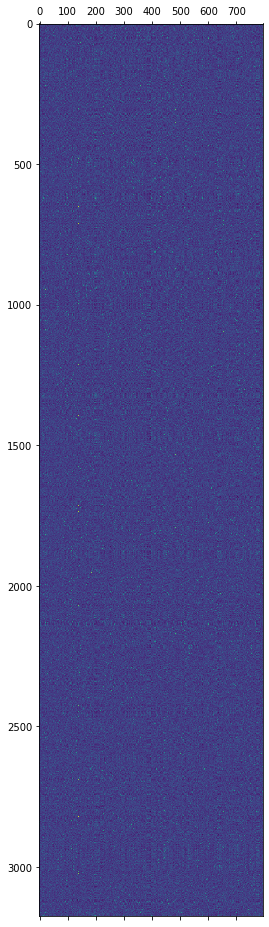

In [ ]:
similarity_matrix = cosine_similarity(train_z_corp, test_z_cop)
f_acc = np.vectorize(lambda x: y_train[x])
acc = f_acc(np.argmax(np.array(similarity_matrix), axis=0))

plt.rcParams['figure.figsize'] = [16, 16]
plt.matshow(similarity_matrix)
plt.show()

In [ ]:
accuracy_score(y_test, acc)

0.9937027707808564

In [ ]:
BATCH_LEN = 100
batches, authors_b = prepare_batches(BATCH_LEN)
x_train, x_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.2, random_state=42)
batches, authors_b = None, None
words_means, words_deviats = prepare_means(x_train)
train_z_corp = z_func(x_train, words_means, words_deviats)
test_z_cop = z_func(x_test, words_means, words_deviats)
similarity_matrix = cosine_similarity(train_z_corp, test_z_cop)
f_acc = np.vectorize(lambda x: y_train[x])
acc = f_acc(np.argmax(np.array(similarity_matrix), axis=0))
accuracy_score(y_test, acc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6396 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

0.938125

In [ ]:
BATCH_LEN = 20
batches, authors_b = prepare_batches(BATCH_LEN)
x_train, x_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.2, random_state=42)
batches, authors_b = None, None
words_means, words_deviats = prepare_means(x_train)
train_z_corp = z_func(x_train, words_means, words_deviats)
test_z_cop = z_func(x_test, words_means, words_deviats)
similarity_matrix = cosine_similarity(train_z_corp, test_z_cop)
f_acc = np.vectorize(lambda x: y_train[x])
acc = f_acc(np.argmax(np.array(similarity_matrix), axis=0))
accuracy_score(y_test, acc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/32141 [00:00<?, ?it/s]

  0%|          | 0/8036 [00:00<?, ?it/s]

0.555873568939771

In [ ]:
BATCH_LEN = 10
batches, authors_b = prepare_batches(BATCH_LEN)
x_train, x_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.2, random_state=42)
batches, authors_b = None, None
words_means, words_deviats = prepare_means(x_train)
train_z_corp = z_func(x_train, words_means, words_deviats)
test_z_cop = z_func(x_test, words_means, words_deviats)
similarity_matrix = cosine_similarity(train_z_corp, test_z_cop)
f_acc = np.vectorize(lambda x: y_train[x])
acc = f_acc(np.argmax(np.array(similarity_matrix), axis=0))
accuracy_score(y_test, acc)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/64322 [00:00<?, ?it/s]

In [ ]:
BATCH_LEN = 5
batches, authors_b = prepare_batches(BATCH_LEN)
x_train, x_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.2, random_state=42)
batches, authors_b = None, None
words_means, words_deviats = prepare_means(x_train)
train_z_corp = z_func(x_train, words_means, words_deviats)
test_z_cop = z_func(x_test, words_means, words_deviats)
similarity_matrix = cosine_similarity(train_z_corp, test_z_cop)
f_acc = np.vectorize(lambda x: y_train[x])
acc = f_acc(np.argmax(np.array(similarity_matrix), axis=0))
accuracy_score(y_test, acc)

In [ ]:
x_train, x_test, y_train, y_test = None, None, None, None
words_means, words_deviats = None, None
train_z_corp, test_z_corp = None, None

***FREQUENCIES AND TSAI***

In [ ]:
tsai_batches = []
tsai_authors_b = []
tsai_batch_len = 200
for i in tqdm_notebook(range(0, len(sentences_all))):
    for j in range(0, len(sentences_all[i]) - tsai_batch_len, tsai_batch_len):
        batch = []
        for sent in sentences_all[i][j:j + tsai_batch_len]:
            batch.append(Counter(sent))
        tsai_batches.append(batch)
        tsai_authors_b.append(authors_sl[i])


x_train, x_test, y_train, y_test = train_test_split(tsai_batches, tsai_authors_b, test_size=0.2, random_state=42)

def prepare_means2(means_from):
    words_means = {}
    words_deviats = {}
    tmp = [functools.reduce(operator.add, sents) for sents in tqdm_notebook(means_from)]
    for word in tqdm_notebook(frequent_c.items()):
        word = word[0]
        mean = 0
        deviat = 0
        for doc in tmp:
            mean += doc[word]/sum(doc.values())
        mean *= 1 / len(tmp)
        words_means[word] = mean
        for doc in tmp:
            deviat += (doc[word]/sum(doc.values()) - mean)**2
        deviat = math.sqrt(1 / (len(tmp) - 1) * deviat)
        words_deviats[word] = deviat
    return words_means, words_deviats

words_means, words_deviats = prepare_means2(x_train)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3970 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
tsai_data = []
for batch in tqdm_notebook(tsai_batches):
    data = np.zeros((len(batch), len(frequent_c)))
    for i, sent in enumerate(batch):
        total = sum(sent.values())
        for j, word in enumerate(frequent_c.items()):
            word = word[0]
            try:
                data[i, j] = (sent[word]/total - words_means[word]) / words_deviats[word]
            except ZeroDivisionError:
                pass
    tsai_data.append(data)

  0%|          | 0/3970 [00:00<?, ?it/s]

In [ ]:
#splits = get_splits(tsai_authors_b, valid_size=.2, stratify=True, random_state=23, shuffle=True)
clf = TSClassifier(tsai_data, tsai_authors_b, splits=splits, path='models', arch=InceptionTime, metrics=accuracy)
clf.fit_one_cycle(100, 3e-4)
clf.export("clf_RTX.pkl")